In [154]:
import matplotlib.pyplot as plt
# import pyro
# import pyro.distributions as dist
# from pyro.infer import SVI, Trace_ELBO
# from pyro.infer.autoguide import AutoDelta, AutoNormal, init_to_sample
# from pyro.optim import Adam
import torch
import torch.distributions as dist
from torch.distributions.transforms import ExpTransform, PowerTransform
from torch.distributions.transformed_distribution import TransformedDistribution
from torch.optim import Adam
from tqdm.auto import trange

## Setup

In [231]:
# Create some weird skewed distribution
def log_prob_p_un(th):
    return -th**2 - 2 * torch.log(torch.exp(-th / 0.05) + 20)

th_grid = torch.linspace(-20, 20, 10000)
log_norm = torch.trapz(log_prob_p_un(th_grid).exp(), th_grid).log()
log_prob_p = lambda th: log_prob_p_un(th) - log_norm

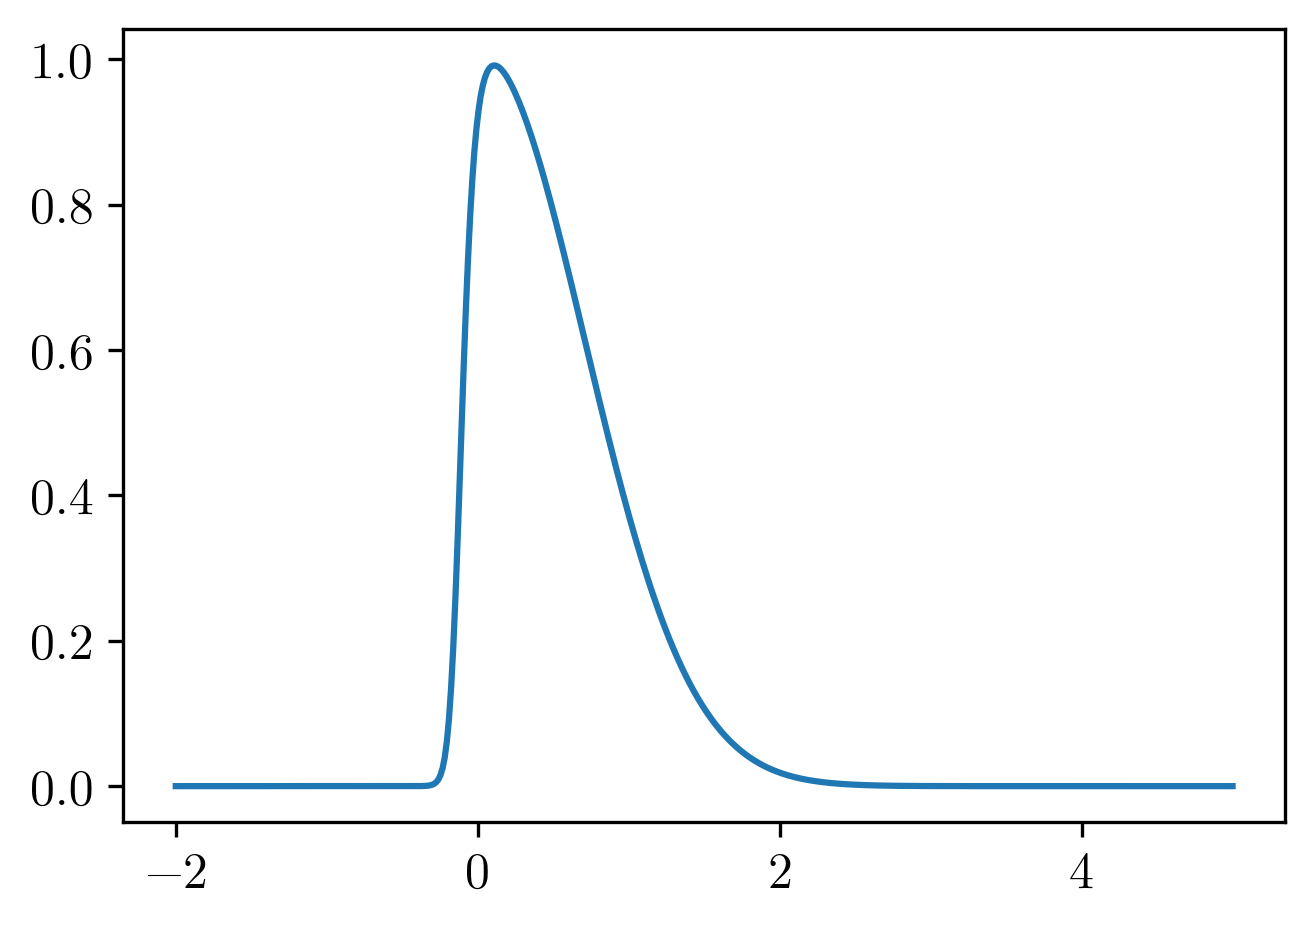

In [232]:
# Plot it to check it looks ok
th_grid = torch.linspace(-2, 5, 1000)
plt.plot(ths, log_prob_p(ths).exp())

## MAP

In [260]:
th0 = torch.tensor(1.0, requires_grad=True)
opt = Adam([th0], lr=0.0003)
losses = []

# Save snapshots
frequency = 100
th0s = []
log_posts = []

for i in trange(5000):
    opt.zero_grad()
    loss = -log_prob_p(th0).sum()
    
    if i % frequency == 0:
        th0s.append(th0.item())
        log_posts.append(-loss.item())
    
    loss.backward()
    losses.append(loss.item())
    opt.step()

  0%|          | 0/5000 [00:00<?, ?it/s]

In [261]:
th_grid = torch.linspace(-1, 3, 500)

for i, (th0, log_post) in enumerate(zip(th0s, log_posts)):
    plt.figure(dpi=200)
    plt.plot(th_grid, log_prob_p(th_grid).exp(), label="Target")
    plt.title(f"$\log p(\eta|x) = {log_post:.2f}$")
#     for t in th:
    plt.axvline(th0, c="C1", label="MAP estimate")
    plt.xlabel("$\eta$")
    plt.ylabel(r"$p(\eta | x)$")
    plt.xlim(-1, 3)
    plt.ylim(0, 1.05)
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.savefig(f"snapshots/map-fig-{i}.png", facecolor="white")
    plt.close()
#     break

## SVI

In [249]:
mu = torch.tensor(1.0, requires_grad=True)
sigma = torch.tensor(0.1, requires_grad=True)
opt = Adam([mu, sigma], lr=0.002)
n_particles = 3
losses = []

# Save snapshots
frequency = 100
ths = []
elbos = []
mus = []
sigmas = []

for i in trange(5000):
    opt.zero_grad()
    q = dist.Normal(mu, sigma)
    th = q.sample((n_particles,))
    loss = (q.log_prob(th).exp() * (q.log_prob(th) - log_prob_p(th))).sum()
    
    if i % frequency == 0:
        ths.append(th)
        elbos.append(-loss.item())
        mus.append(mu.item())
        sigmas.append(sigma.item())
    
    loss.backward()
    losses.append(loss.item())
    opt.step()

  0%|          | 0/5000 [00:00<?, ?it/s]

In [251]:
th_grid = torch.linspace(-1, 3, 500)

for i, (th, elbo, mu, sigma) in enumerate(zip(ths, elbos, mus, sigmas)):
    plt.figure(dpi=200)
    plt.plot(th_grid, log_prob_p(th_grid).exp(), label="Target")
    plt.plot(
        th_grid, dist.Normal(mu, sigma).log_prob(th_grid).exp().detach(), label="Approx"
    )
    plt.title(f"ELBO = {elbo:.2f}")
#     for t in th:
    plt.axvline(th[0], c="C1", linewidth=0.5)
    plt.xlabel("$\eta$")
    plt.ylabel(r"$p(\eta | x)$")
    plt.xlim(-1, 3)
    plt.ylim(0, 1.05)
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.savefig(f"snapshots/fig-{i}.png", facecolor="white")
    plt.close()